# Construcción de dataset para detección de objetos en la nevera

### **Objetivo**

El objetivo de este notebook es detallar el proceso seguido para la construcción del set de datos utilizado posteriormente para entrenar el modelo de detección de objetos YOLO (You Only Look Once), un algoritmo de visión computerizada que permite localizar e identificar objetos mediante cajas delimitadas (bounding boxes en inglés). 

El set de datos final se construirá a partir de una combinación de lo siguiente:
- `Datasets públicos`: Algunos datasets ya optimizados para la detección de objetos dentro de la nevera con las clases etiquetadas. Sin embargo, no se ha podido cubrir las 30 clases de alimentos seleccionadas previamente en el análisis exploratorio dado que no hay fotos de algunos alimentos dentro de una nevera.
- `Datasets sintéticos`: creados a partir de un script de python que toma imágenes individuales de ingredientes (en formato .png) y las coloca aleatoriamente sobre distintos fondos de neveras vacías. Esta técnica nos permite suplementar los datasets públicos cuyas fotos no incluyen algunas de las clases que necesitamos identificar.

**Ejemplo ilustrativo:**
1) Nuestro objetivo es identificar ["pepino", "tomate", "huevos"] en fotos de nevera
2) De datasets públicos, hemos encontrado fotos de nevera disponibles con ["pepino"]
3) Con un script de python, construimos datasets sintéticos donde aleatoriamente (para simular una situación realista) se colocan fotos de huevos y tomate en diferentes fondos de nevera. 
4) Al combinar 2 y 3 obtenemos un dataset final con todas las clases de comida que intentamos identificar con el modelo YOLO

## 1. Procesamiento de datasets públicos

### 1.1) Imports

In [1]:
import os
import shutil
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random
from rembg import remove
from IPython.display import Image as Image_
from IPython.display import display, HTML
from PIL import Image
import re
import albumentations as A
import cv2
from tqdm import tqdm

c:\Users\oscar.xu\AppData\Local\anaconda3\envs\tfm_env_final\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2) Datasets públicos descargados

Se han descargado los siguientes datasets públicos de Roboflow, platforma online similar a Kaggle donde usuarios suben sets de datos y modelos entrenados de referencia:
- Dataset 1 - 3268 imágenes - https://universe.roboflow.com/james-elcock/fridge-detection-ojugs/browse?queryText=&pageSize=50&startingIndex=0&browseQuery=true
- Dataset 2 - 1831 imágenes - https://universe.roboflow.com/recipe-recomendation-app/fridge-detection-merged/dataset/4
- Dataset 3 - 2141 imágenes - https://universe.roboflow.com/fridge-6oahv/fridge-vstlk/dataset/1
- Dataset 4 - 2023 imágenes - https://universe.roboflow.com/neveraflow/nadaenlanevera/dataset/1

Estos datasets contienen fotos con cajas ya delimitadas para cada clase de alimento. Por ejemplo:


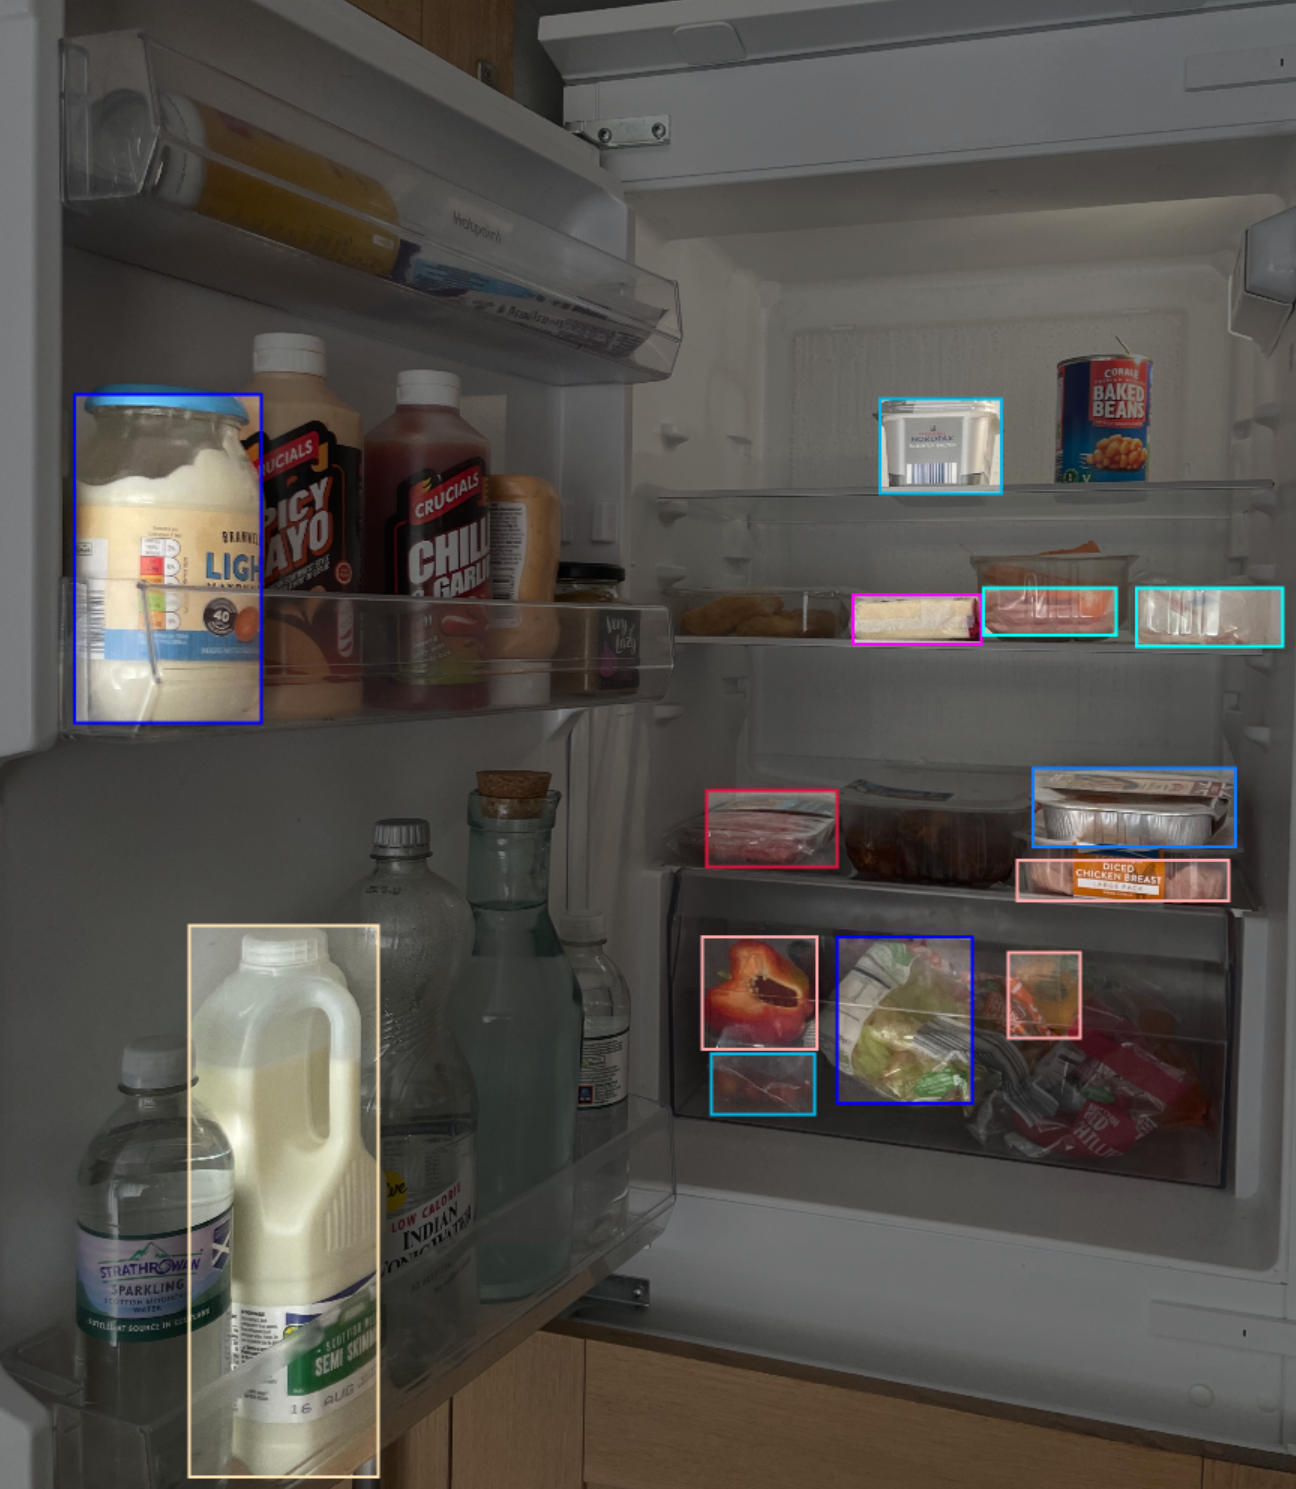

In [9]:
Image_(filename=r'..\notebooks\examples\public dataset example.png', width=400, height=200)

Todos los dataset públicos están optimizados con el formato YOLO. YOLO requiere los siguientes archivos y carpetas para poder funcionar:

Típicamente en cada set de datos tenemos 3 subcarpetas: 
- `train`: imágenes utilizadas para el entrenamiento del modelo
- `val`: imágenes utiizadas para la validación del modelo durante el entrenamiento
- `test`: imágenes que no ha visto el modelo antes, utilizado para una validación final.

En cada subcarpeta tendremos:
- `images`: una carpeta donde están las imágenes utilizadas para entrenar
- `labels`: una carpeta que contiene archivos .txt con las anotaciones de cada imagen. En las anotaciones tenemos "coordenadas y tamaño" para las cajas delimitadas y el número id de la clase en sí.
    - El formato en los archivos de texto es el siguiente:
    `<class_id> <x_center> <y_center> <width> <height>`
    - Por ejemplo: 24 0.47734375 0.93359375 0.1671875 0.1328125. El número 24 corresponde a una clase específica de comida, por ejemplo "tomate". Mientras que los otros números definen las coordinadas y el tamaño de la caja delimitada.
- `data.yaml`: esto es un archivo que especficia lo siguiente:
    - La ruta de las diferentes carpetas `train`, `val`, `test`
    - La cantidad total de clases únicas que hay `nc`
    - También contiene la lista de nombres de clases (los nombres se mapean a ids por índice. Es decir si tenemos una lista ['manzana', 'tomate', 'pepino'], manzana será 0, tomate 1 y pepino 2)

### 1.3) Procesamiento de datasets públicos

Una vez descargados los datasets públicos, necesitamos combinar los diferentes datasets en uno. Sin embargo tenemos las siguientes complicaciones:
- Cada dataset público tiene un mapeo diferente de `id <> nombre de clase`. Es decir, en el dataset 1 el id 4 puede equivaler a tomate, pero en el dataset 2, el tomate puede tener id 10.
    - Para resolver esto, se ha definido un diccionario de mapeo global y se construye una función para procesar cada dataset y reasignar los ids de cada clase en acorde al mapeo global
- Cada dataset ya está dividido en `train`, `val` y `test`. Antes de combinarlos, es necesario aplanar cada dataset (es decir, juntar todas las imágenes y etiquetas en carpetas únicas). Esto es mejor que combinar todas las carpetas `train`, `val` y `test` de todos los datastes porque no sería un split aleatorio real.
- Los nombres de las clases están en inglés 
    - Para resolver esto, se han traducido manualmente los nombres de clase que necesitados de inglés al español.

In [10]:
# Definiendo un diccionario con un mapping global a usar en funciones posteriores
classes_mapping = {
    "Tomate": 0,
    "Cebolla": 1,
    "Patata": 2,
    "Lechuga/Endivia": 3,
    "Zanahoria": 4,
    "Calabacines": 5,
    "Pepino": 6,
    "Champiñones": 7,
    "Brocoli": 8,
    "Coliflor": 9,
    "Leche": 10,
    "Huevos": 11,
    "Yogur": 12,
    "Queso": 13,
    "Mantequilla": 14,
    "Merluza": 15,
    "Gambas/Langostinos": 16,
    "Mix de marisco/molusco": 17,
    "Lubina": 18,
    "Salmón": 19,
    "Plátano": 20,
    "Aguacate": 21,
    "Sandía": 22,
    "Limón": 23,
    "Manzana": 24,
    "Carne pollo": 25,
    "Carne cerdo": 26,
    "Carne vacuno": 27,
    "Salchichas": 28,
    "Carne pavo": 29
}

# Función para reasignar el mapeo id <> nombre clase 
def renumber_yolo_dataset_flat_output(
    dataset_root: str,
    output_root: str,
    target_classes: list,
    splits: list = ['train', 'valid', 'test'],
    image_ext: str = '.jpg'
):
    """
    Procesa un dataset de YOLO y aplana el dataset juntando las 
    imágenes y etiquetas en carpetas únicas `images/` y `labels/` (en lugar de tenerlas en trian, val, test).  
    Los IDs de cada dataset se remapean en acorde a un mapeo global llamado classes_mapping.
    La función salta imágenes que no tenga ninguna clase dentro de los 30 que buscamos.

    Flujo:
    ------
        1. Lee el archivo `data.yaml` del dataset para obtener los nombres de clase.
        2. Construye un mapeo entre los IDs originales y los IDs globales.
        3. Itera sobre los splits especificados (`train`, `valid`, `test`).
        4. Copia imágenes y etiquetas remapeadas a las carpetas de salida planas.
        5. Omite imágenes cuyas etiquetas no incluyan clases objetivo (dado que no nos interesan todas las clases de las fotos).

    Parámetros:
    -----------
        dataset_root: Carpeta raíz del dataset YOLO (con subcarpetas de splits).
        output_root: Carpeta de destino donde se creará el dataset plano.
        target_classes: Lista de nombres de clase a conservar (no nos interesan todas las clases de todas las fotos)
        splits: Splits del dataset a procesar.  
                                 Por defecto: ['train', 'valid', 'test'].
        image_ext: Extensión de las imágenes.  
                                   Por defecto: ".jpg".
    """


    # Cargar los nombres de clases desde data.yaml del dataset actual
    data_yaml_path = os.path.join(dataset_root, 'data.yaml')
    with open(data_yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
    original_names = data_yaml['names']

    # Crea un mapeo: original class ID → global class ID
    original_to_global = {}
    for class_name in target_classes:
        if class_name in original_names and class_name in classes_mapping:
            original_id = original_names.index(class_name)
            global_id = classes_mapping[class_name]
            original_to_global[original_id] = global_id

    print(f"[{os.path.basename(dataset_root)}] Mapeo: {original_to_global}")

    total_kept, total_skipped = 0, 0

    # Crea carpetas únicas de images y labels
    out_img_dir = os.path.join(output_root, 'images')
    out_lbl_dir = os.path.join(output_root, 'labels')
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    for split in splits:
        split_img_dir = os.path.join(dataset_root, split, 'images')
        split_lbl_dir = os.path.join(dataset_root, split, 'labels')

        if not os.path.exists(split_img_dir) or not os.path.exists(split_lbl_dir):
            print(f"Skipping {split}: missing directories.")
            continue

        for label_file in os.listdir(split_lbl_dir):
            if not label_file.endswith('.txt'):
                continue

            label_path = os.path.join(split_lbl_dir, label_file)
            with open(label_path, 'r') as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if not parts:
                    continue
                class_id = int(parts[0])
                if class_id in original_to_global:
                    parts[0] = str(original_to_global[class_id])
                    new_lines.append(' '.join(parts) + '\n')

            if new_lines:
                total_kept += 1
                out_lbl_path = os.path.join(out_lbl_dir, label_file)
                with open(out_lbl_path, 'w') as f:
                    f.writelines(new_lines)

                img_file = label_file.replace('.txt', image_ext)
                src_img_path = os.path.join(split_img_dir, img_file)
                dst_img_path = os.path.join(out_img_dir, img_file)

                if os.path.exists(src_img_path):
                    shutil.copyfile(src_img_path, dst_img_path)
            else:
                total_skipped += 1

    print(f"[{os.path.basename(dataset_root)}] Completado: {total_kept} imágenes guardadas, {total_skipped} saltadas.")

In [ ]:
target_classes = [
    "Tomate", "Cebolla", "Patata", "Lechuga/Endivia", "Zanahoria",
    "Calabacines", "Pepino", "Champiñones", "Brocoli", "Coliflor",
    "Leche", "Huevos", "Yogur", "Queso", "Mantequilla",
    "Merluza", "Gambas/Langostinos", "Mix de marisco/molusco", "Lubina", "Salmón",
    "Plátano", "Aguacate", "Sandía", "Limón", "Manzana", "Carne pollo", "Carne cerdo", "Carne vacuno", "Salchichas", "Carne pavo"
]
dataset_root = r'..\dataset\YOLO - Raw datasets\Raw Datasets\Raw Dataset 1'
output_root = r'..\dataset\YOLO - Clean dataset\Clean dataset 1'
renumber_yolo_dataset_flat_output(dataset_root=dataset_root, output_root=output_root, target_classes=target_classes)

[Raw Dataset 1] Mapeo: {37: 0, 27: 1, 30: 2, 20: 3, 7: 4, 23: 7, 5: 8, 22: 10, 12: 11, 24: 12, 8: 13, 6: 14, 31: 16, 1: 20, 19: 23, 0: 24, 9: 25, 17: 26, 2: 27}
[Raw Dataset 1] Completado: 7526 imágenes guardadas, 115 saltadas.


Después de procesar cada dataset público, chequeamos cual es la cobertura de cada clase de comida (tenemos 30 en total). Esto es para monitorizar qué clases están poco representadas en las fotos de nevera por si hiciera falta encontrar más fotos o construir fotos sintéticas (la opción escogida) que incluyan estas clases.

In [ ]:
def count_classes_in_images(label_dir, class_names=None):
    """
    Cuenta en cuántas imágenes aparece cada clase, basándose en los archivos de 
    etiquetas YOLO (`.txt`). Esta función cuenta una clase como 
    máximo una vez por imagen, incluso si aparece mucha veces (por ejemplo, hay más de una manzana)

    Parámetros:
    -----------
        label_dir: Ruta a la carpeta que contiene los archivos de etiquetas 
                         YOLO (extensión `.txt`).
        class_names: Lista de nombres de clase indexados por ID.  

    Devuelve:
    ---------
        dict: Diccionario `class_id → número_de_imágenes` que indica en cuántas 
              imágenes aparece cada clase.  
    """
    class_image_counts = defaultdict(int)

    for file in os.listdir(label_dir):
        if not file.endswith('.txt'):
            continue

        with open(os.path.join(label_dir, file), 'r') as f:
            lines = f.readlines()

        try:
            classes_in_image = set(int(float(line.split()[0])) for line in lines if line.strip())
        except ValueError as e:
            print(f"Error: {file} — {e}")
            continue

        for class_id in classes_in_image:
            class_image_counts[class_id] += 1

    # Esto se asegura que devuelve todas las clases, aunque sea 0
    total_classes = len(class_names) if class_names else max(class_image_counts.keys(), default=-1) + 1

    print(f"\nClass distribution in '{label_dir}':\n")
    for class_id in range(total_classes):
        count = class_image_counts.get(class_id, 0)
        class_name = class_names[class_id] if class_names and class_id < len(class_names) else f"Class {class_id}"
        print(f"{class_name:30} → {count} image(s)")

    return dict(class_image_counts)

def plot_class_image_distribution(class_counts, class_names=None, title='Class Occurrence in Images'):
    """
    Genera un gráfico de barras que muestra en cuántas imágenes aparece cada clase.

    Parámetros:
    -----------
        class_counts: Diccionario `class_id → número_de_imágenes` que 
                            hemos generado previamente con `count_classes_in_images`.
        class_names: Lista de nombres de clase indexados por ID.  
        title: Título del gráfico.  
    """
    sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    class_ids = [item[0] for item in sorted_items]
    counts = [item[1] for item in sorted_items]

    if class_names:
        labels = [class_names[i] if i < len(class_names) else f"Class {i}" for i in class_ids]
    else:
        labels = [f"Class {i}" for i in class_ids]

    plt.figure(figsize=(14, 6))
    plt.bar(labels, counts)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Class')
    plt.ylabel('Images')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels', class_names=target_classes)


Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 1\labels':

Tomate                         → 4621 image(s)
Cebolla                        → 3152 image(s)
Patata                         → 4233 image(s)
Lechuga/Endivia                → 87 image(s)
Zanahoria                      → 3027 image(s)
Calabacines                    → 0 image(s)
Pepino                         → 0 image(s)
Champiñones                    → 3170 image(s)
Brocoli                        → 84 image(s)
Coliflor                       → 0 image(s)
Leche                          → 2811 image(s)
Huevos                         → 2519 image(s)
Yogur                          → 116 image(s)
Queso                          → 4440 image(s)
Mantequilla                    → 3137 image(s)
Merluza                        → 0 image(s)
Gambas/Langostinos             → 3554 image(s)
Mix de marisco/molusco         → 0 image(s)
Lubina                         → 0 image(s)
Salmón                         → 0 image(s)
Plát

{10: 2811,
 14: 3137,
 23: 110,
 11: 2519,
 3: 87,
 7: 3170,
 2: 4233,
 4: 3027,
 12: 116,
 26: 1467,
 0: 4621,
 24: 2146,
 13: 4440,
 25: 4241,
 1: 3152,
 8: 84,
 27: 2005,
 20: 3350,
 16: 3554}


Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 1\labels':

Tomate                         → 4621 image(s)
Cebolla                        → 3152 image(s)
Patata                         → 4233 image(s)
Lechuga/Endivia                → 87 image(s)
Zanahoria                      → 3027 image(s)
Calabacines                    → 0 image(s)
Pepino                         → 0 image(s)
Champiñones                    → 3170 image(s)
Brocoli                        → 84 image(s)
Coliflor                       → 0 image(s)
Leche                          → 2811 image(s)
Huevos                         → 2519 image(s)
Yogur                          → 116 image(s)
Queso                          → 4440 image(s)
Mantequilla                    → 3137 image(s)
Merluza                        → 0 image(s)
Gambas/Langostinos             → 3554 image(s)
Mix de marisco/molusco         → 0 image(s)
Lubina                         → 0 image(s)
Salmón                         → 0 image(s)
Plát

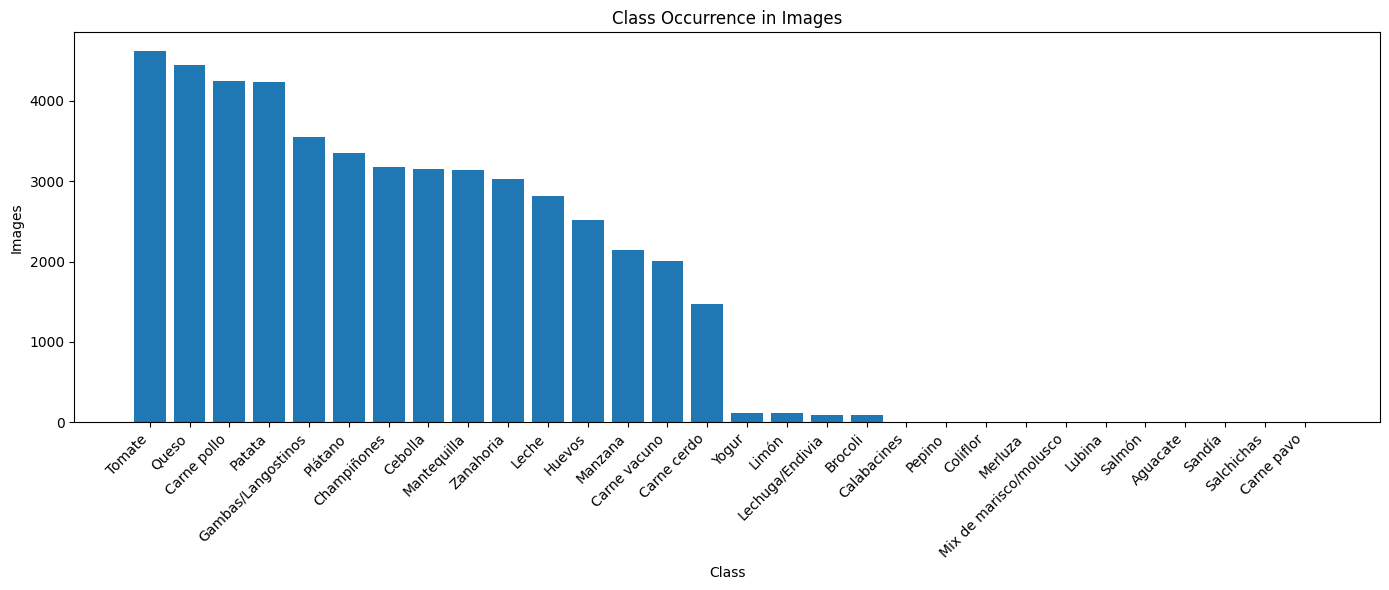

In [48]:
counts = count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels', class_names=target_classes)
full_counts = {i: counts.get(i, 0) for i in range(len(target_classes))} # Hace que se cuenten los que tiene 0 también
plot_class_image_distribution(full_counts, class_names=target_classes)


In [13]:
# Procesando el dataset 2
dataset_root = r'..\dataset\YOLO - Raw datasets\Raw Datasets\Raw Dataset 2'
output_root = r'..\dataset\YOLO - Clean dataset\Clean dataset 1'
renumber_yolo_dataset_flat_output(dataset_root=dataset_root, output_root=output_root, target_classes=target_classes)

[Raw Dataset 2] Mapeo: {20: 0, 13: 3, 6: 4, 9: 6, 16: 10, 10: 11, 21: 12, 7: 13, 5: 14, 2: 20, 1: 21, 12: 23, 0: 24, 8: 25}
[Raw Dataset 2] Completado: 3041 imágenes guardadas, 69 saltadas.



Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 1\labels':

Tomate                         → 5899 image(s)
Cebolla                        → 3152 image(s)
Patata                         → 4233 image(s)
Lechuga/Endivia                → 689 image(s)
Zanahoria                      → 4213 image(s)
Calabacines                    → 0 image(s)
Pepino                         → 643 image(s)
Champiñones                    → 3170 image(s)
Brocoli                        → 84 image(s)
Coliflor                       → 0 image(s)
Leche                          → 4147 image(s)
Huevos                         → 4157 image(s)
Yogur                          → 1084 image(s)
Queso                          → 5784 image(s)
Mantequilla                    → 4315 image(s)
Merluza                        → 0 image(s)
Gambas/Langostinos             → 3554 image(s)
Mix de marisco/molusco         → 0 image(s)
Lubina                         → 0 image(s)
Salmón                         → 0 image(s)


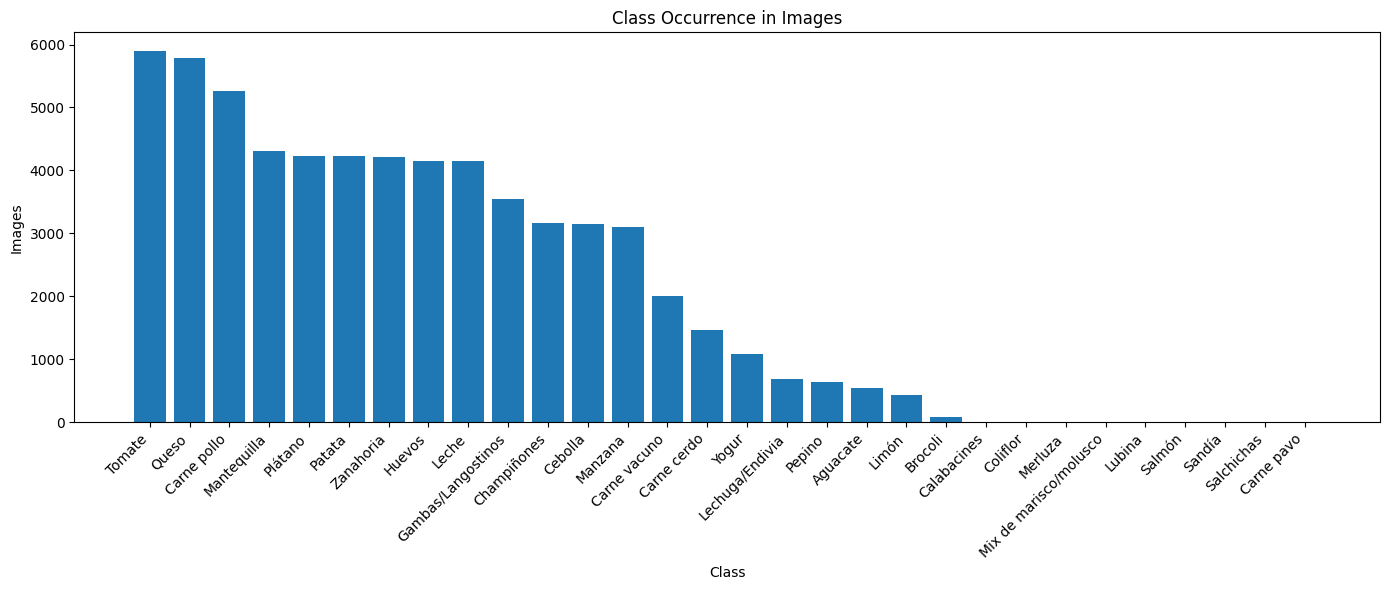

In [50]:
counts = count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels', class_names=target_classes)
full_counts = {i: counts.get(i, 0) for i in range(len(target_classes))} # Hace que se cuenten los que tiene 0 también
plot_class_image_distribution(full_counts, class_names=target_classes)


In [15]:
# Procesando el dataset 3
dataset_root = r'..\dataset\YOLO - Raw datasets\Raw Datasets\Raw Dataset 3'
output_root = r'..\dataset\YOLO - Clean dataset\Clean dataset 1'
renumber_yolo_dataset_flat_output(dataset_root=dataset_root, output_root=output_root, target_classes=target_classes)

[Raw Dataset 3] Mapeo: {12: 0, 5: 1, 8: 2, 53: 3, 26: 4, 59: 7, 2: 8, 3: 9, 39: 11, 87: 12, 28: 13, 25: 14, 76: 16, 0: 20, 4: 23, 13: 24, 29: 25, 48: 26, 21: 27, 75: 28}
[Raw Dataset 3] Completado: 1655 imágenes guardadas, 486 saltadas.



Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 1\labels':

Tomate                         → 5991 image(s)
Cebolla                        → 3162 image(s)
Patata                         → 4245 image(s)
Lechuga/Endivia                → 802 image(s)
Zanahoria                      → 4496 image(s)
Calabacines                    → 0 image(s)
Pepino                         → 643 image(s)
Champiñones                    → 3238 image(s)
Brocoli                        → 124 image(s)
Coliflor                       → 30 image(s)
Leche                          → 4147 image(s)
Huevos                         → 4724 image(s)
Yogur                          → 1701 image(s)
Queso                          → 6498 image(s)
Mantequilla                    → 4747 image(s)
Merluza                        → 0 image(s)
Gambas/Langostinos             → 3609 image(s)
Mix de marisco/molusco         → 0 image(s)
Lubina                         → 0 image(s)
Salmón                         → 0 image(s

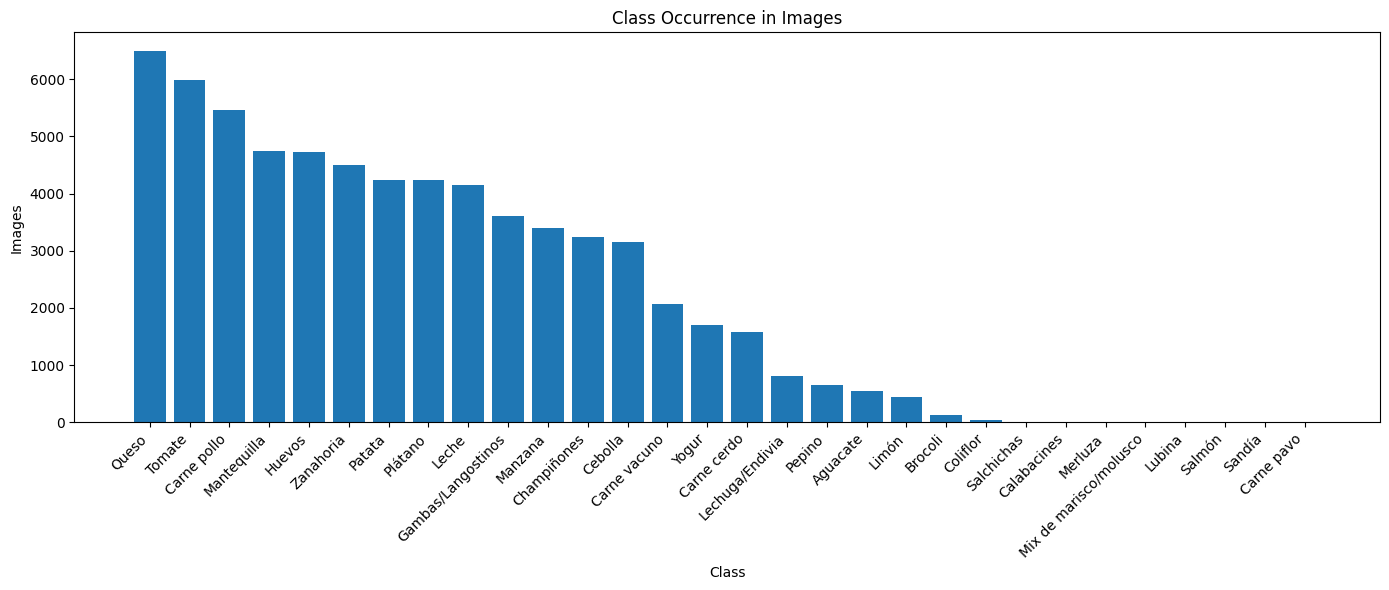

In [ ]:
counts = count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels', class_names=target_classes)
full_counts = {i: counts.get(i, 0) for i in range(len(target_classes))} # Hace que se cuenten los que tiene 0 también
plot_class_image_distribution(full_counts, class_names=target_classes)

In [16]:
# Procesando el dataset 4
dataset_root = r'..\dataset\YOLO - Raw datasets\Raw Datasets\Raw Dataset 4'
output_root = r'..\dataset\YOLO - Clean dataset\Clean dataset 1'
renumber_yolo_dataset_flat_output(dataset_root=dataset_root, output_root=output_root, target_classes=target_classes)

[Raw Dataset 4] Mapeo: {33: 0, 4: 1, 12: 3, 36: 4, 22: 6, 3: 8, 11: 10, 8: 11, 35: 12, 29: 13, 15: 14, 27: 20, 1: 21, 13: 23, 16: 24, 31: 28, 21: 29}
[Raw Dataset 4] Completado: 1883 imágenes guardadas, 140 saltadas.



Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 1\labels':

Tomate                         → 6379 image(s)
Cebolla                        → 3212 image(s)
Patata                         → 4245 image(s)
Lechuga/Endivia                → 1216 image(s)
Zanahoria                      → 4737 image(s)
Calabacines                    → 0 image(s)
Pepino                         → 751 image(s)
Champiñones                    → 3238 image(s)
Brocoli                        → 322 image(s)
Coliflor                       → 30 image(s)
Leche                          → 4664 image(s)
Huevos                         → 4987 image(s)
Yogur                          → 2413 image(s)
Queso                          → 6775 image(s)
Mantequilla                    → 4904 image(s)
Merluza                        → 0 image(s)
Gambas/Langostinos             → 3609 image(s)
Mix de marisco/molusco         → 0 image(s)
Lubina                         → 0 image(s)
Salmón                         → 0 image(

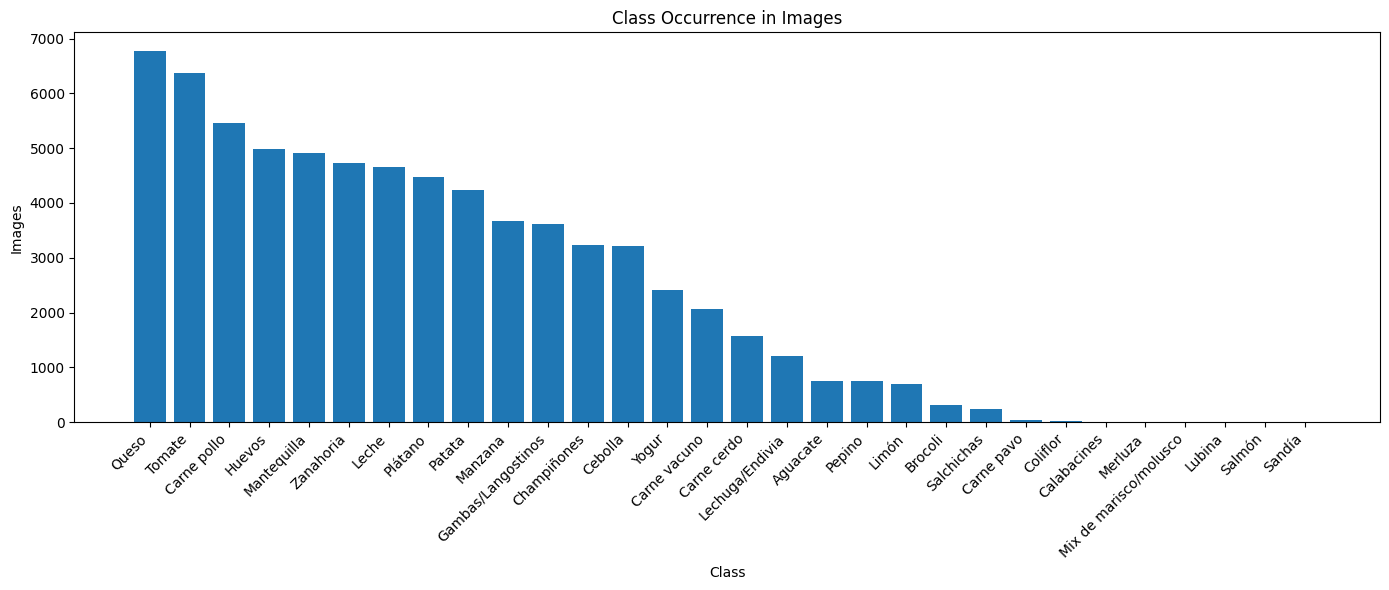

In [54]:
counts = count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels', class_names=target_classes)
full_counts = {i: counts.get(i, 0) for i in range(len(target_classes))} # Hace que se cuenten los que tiene 0 también
plot_class_image_distribution(full_counts, class_names=target_classes)

### 1.4) Split del dataset

Una vez combinados los 4 datasets públicos descargados con todas las imágenes y textos en carpetas únicas, hacemos un split aleatorio en `train`, `val`, `test`. No se han unido directamente las carpetas train, val y test de cada dataset, sino que se ha optado por aplanar primero y dividir de nuevo.
De esta forma se previenen sesgos heredados de los splits originales y se reduce el riesgo de desequilibrio entre clases en los conjuntos finales.

In [1]:
def split_yolo_dataset(
    image_dir,
    label_dir,
    output_dir,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=42
):
    """
    Divide un dataset combinado en tres subconjuntos: `train`, `val` y `test`.

    La función empareja imágenes y sus archivos de etiquetas correspondientes,
    los baraja aleatoriamente, y luego los distribuye en las carpetas de salida
    según las proporciones indicadas. El resultado mantiene la estructura típica
    de YOLO:

        output_dir/
         ├── train/
         │    ├── images/
         │    └── labels/
         ├── val/
         │    ├── images/
         │    └── labels/
         └── test/
              ├── images/
              └── labels/

    Parámetros:
    -----------
        image_dir: Carpeta que contiene las imágenes
        label_dir: Carpeta que contiene los archivos de etiquetas YOLO (`.txt`).
        output_dir: Carpeta raíz donde se guardarán los subconjuntos generados.
        train_ratio: Proporción de datos destinada a entrenamiento (70% por defecto).
        val_ratio: Proporción de datos destinada a validación (15% por defecto).
        test_ratio: Proporción de datos destinada a prueba (15% por defecto).
        seed: Semilla para la aleatorización de los splits.Por defecto = 42.

    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios tienen que sumar 1 en total."

    random.seed(seed)

    # Paso 1: Emparejando imagenes-etiquetas
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    matched_pairs = []
    for img_file in image_files:
        base = os.path.splitext(img_file)[0]
        label_file = f"{base}.txt"
        if os.path.exists(os.path.join(label_dir, label_file)):
            matched_pairs.append((img_file, label_file))

    # Paso 2: Randomiza y hace un split del dataset combinado a train, val, test
    random.shuffle(matched_pairs)
    total = len(matched_pairs)
    n_train = int(total * train_ratio)
    n_val = int(total * val_ratio)

    train_set = matched_pairs[:n_train]
    val_set = matched_pairs[n_train:n_train + n_val]
    test_set = matched_pairs[n_train + n_val:]

    # Paso 3: Copia los archivos
    def copy_files(pairs, split_name):
        img_out = os.path.join(output_dir, split_name, "images")
        lbl_out = os.path.join(output_dir, split_name, "labels")
        os.makedirs(img_out, exist_ok=True)
        os.makedirs(lbl_out, exist_ok=True)
        for img, lbl in pairs:
            shutil.copyfile(os.path.join(image_dir, img), os.path.join(img_out, img))
            shutil.copyfile(os.path.join(label_dir, lbl), os.path.join(lbl_out, lbl))

    copy_files(train_set, "train")
    copy_files(val_set, "val")
    copy_files(test_set, "test")

    # Resumen
    print(f"Split completado:")
    print(f"   → Train: {len(train_set)}")
    print(f"   → Val:   {len(val_set)}")
    print(f"   → Test:  {len(test_set)}")


In [ ]:
split_yolo_dataset(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\images', r'..\dataset\YOLO - Clean dataset\Clean dataset 1\train_test_val_dataset - 1st iteration')

Split completado:
   → Train: 9873
   → Val:   2115
   → Test:  2117


## 2. Construcción de un dataset sintético

Previamente, hemos unido todos los datasets públicos descargados. Se comprueba el conteo de número de fotos en las que aparecen diferentes clases para observar qué clases están subrepresentadas.


Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 1\labels':

Tomate                         → 6379 image(s)
Cebolla                        → 3212 image(s)
Patata                         → 4245 image(s)
Lechuga/Endivia                → 1216 image(s)
Zanahoria                      → 4737 image(s)
Calabacines                    → 0 image(s)
Pepino                         → 751 image(s)
Champiñones                    → 3238 image(s)
Brocoli                        → 322 image(s)
Coliflor                       → 30 image(s)
Leche                          → 4664 image(s)
Huevos                         → 4987 image(s)
Yogur                          → 2413 image(s)
Queso                          → 6775 image(s)
Mantequilla                    → 4904 image(s)
Merluza                        → 0 image(s)
Gambas/Langostinos             → 3609 image(s)
Mix de marisco/molusco         → 0 image(s)
Lubina                         → 0 image(s)
Salmón                         → 0 image(

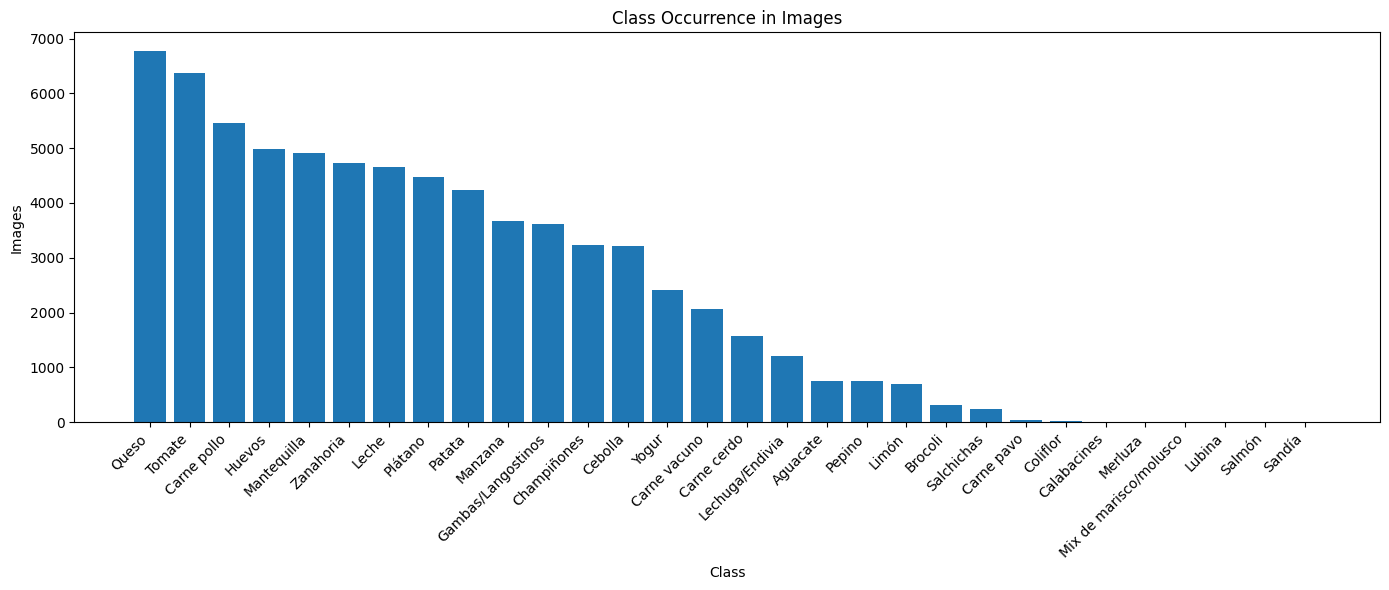

In [12]:
counts = count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 1\labels', class_names=target_classes)
full_counts = {i: counts.get(i, 0) for i in range(len(target_classes))} # Hace que se cuenten los que tiene 0 también
plot_class_image_distribution(full_counts, class_names=target_classes)

Vemos a traves de la gráfica que hay ciertas clases que tienen muy buena representación como:
- Queso, tomate, carne pollo, huevos, etc.

Sin embargo, tenemos clases que no tienen o casi no tienen representación:
- Merluza, mix de marisco, lubina, salmón, sandía

Para las clases con poca representación, porque no se han encontrado datasets públicos con fotos de nevera con esas clases en ella, se ha construido fotos sintéticas para simular fotos realistas de neveras incluyendo estas clases.

El proceso de construir el dataset sintético es el siguiente:
- En primer lugar se han descargado fotos de clases con poca representación. En concreto, se han descargado fotos de estas siguientes clases: `['Aguacate', 'Brocoli','Calabacines', 'Carne pavo', 'Carne vacuno', 'Coliflor', 'Lechuga/Endivia', 'Limón', 'Lubina', 'Manzana', 'Merluza', 'Mix de marisco/molusco', 'Pepino', 'Salchichas', 'Salmón', 'Sandía', 'Yogur']`
    - Las imágenes se han descargado desde páginas de supermmercados como Día, Carrefour y https://es.openfoodfacts.org/ para tener fotos de productos que sean realistas y similares a los comprados en España. Adicionalmente, las fotos subidas a https://es.openfoodfacts.org/ son realizadas por usuarios y vienen en diferentes ángulos/posturas, lo que ayuda al realismo del set de datos sintético.
- En segundo lugar, se han descargado imágenes de **neveras vacías**.

- Las imágenes usualmente vienen con un fondo que dificultaría la fusión con las fotos de nevera. Por lo tanto, se usará una función para quitarles el fondo.

- Una vez listas las imágenes de ingredientes sin fondo y las fotos de nevera, se utilizará una función de python para posicionar aleatoriamente imágenes de ingredientes (clases poco representadas) en fondos de nevera para **crear un set de fotos sintéticas** que intentan simular fotos de nevera realistas.
    - Para aumentar la diversidad del dataset sintético, se usan `técnicas de augmentación` ya que las imágenes de ingredientes se posicionan en diferentes lugares de la nevera, y en diferentes fondos de nevera con variaciones en tamaño y orientación aleatoria. Esto ayuda a simular situaciones más realistas y también evita que el modelo simplemente memorice patrones.
    - El otro objetivo del dataset sintético es equilibrar más las clases y hacer que todas las clases tengan una representación decente

### 2.1) Eliminación de fondos en fotos de ingredientes

A continuación, eliminamos los fondos de las imágenes de ingredientes:

In [ ]:
# Utilizamos el siguiente código para eliminar los fondos de las imágenes.
input_dir = r'..\dataset\YOLO - Raw datasets\Ingredients\Raw Ingredients - with background'
output_dir = r'..\dataset\YOLO - Raw datasets\Ingredients\Ingredients - without background'

os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(input_dir):
    if file.endswith(('.jpg', '.jpeg', '.png')):
        input_path = os.path.join(input_dir, file)
        output_path = os.path.join(output_dir, file.replace('.jpg', '.png'))

        with open(input_path, 'rb') as inp:
            raw = inp.read()
            result = remove(raw)

        with open(output_path, 'wb') as out:
            out.write(result)

print("✔ Proceso completato. Se han eliminado los fondos y las nuevas imágenes se han guardado en:", output_dir)


✔ Proceso completato. Se han eliminado los fondos y las nuevas imágenes se han guardado en: ..\dataset\YOLO - Raw datasets\Ingredients\Ingredients - without background


In [ ]:
# Ejemplo de foto procesada
html = """
<div style="display: flex; gap: 20px;">
    <div>
        <p>Con fondo</p>
        <img src="../dataset/YOLO - Raw datasets/Ingredients/Raw Ingredients - with background/Aguacate 1.jpg" width="300">
    </div>
    <div>
        <p>Sin fondo</p>
        <img src="../dataset/YOLO - Raw datasets/Ingredients/Ingredients - without background/Aguacate 1.png" width="300">
    </div>
</div>
"""
display(HTML(html))


### 2.2) Delimitación de areas en las fotos de neveras

Tal y como se ha mencionado previamente, se han descargado fotos de nevera (en total 21 fotos diferentes) para poder posicionar fotos de ingredientes sin fotos aleatoriamente para simular fotos de nevera realistas. A continuación se muestran algunos ejemplos de las fotos descargadas:

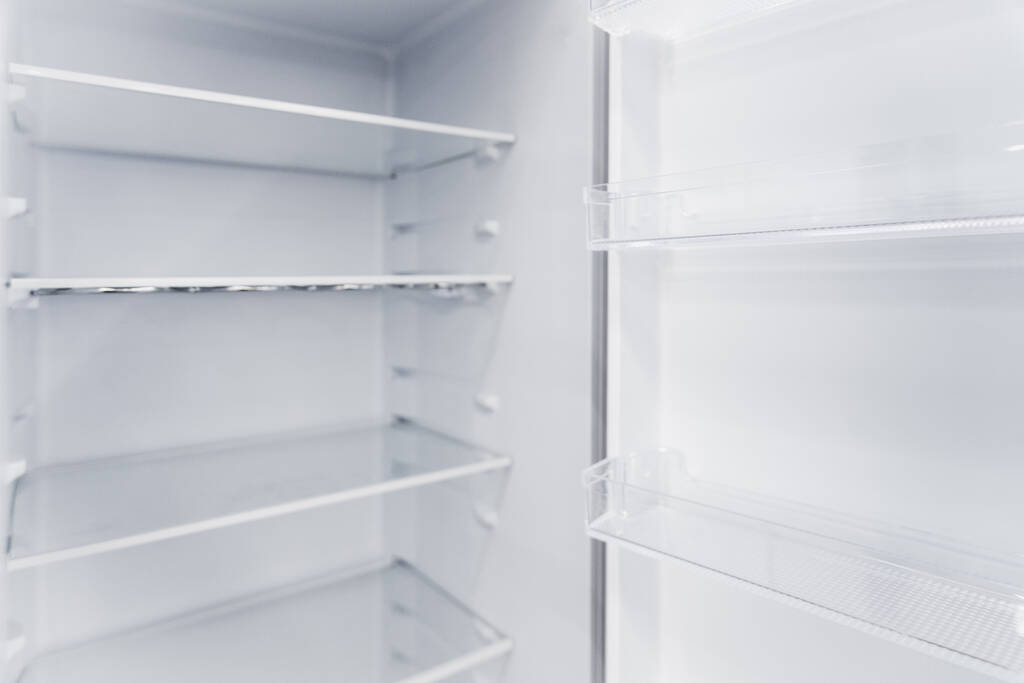

In [2]:
Image_(r'..\dataset\YOLO - Raw datasets\Fridge\Fridge pictures\Fridge 17.jpg',width=400, height=200)

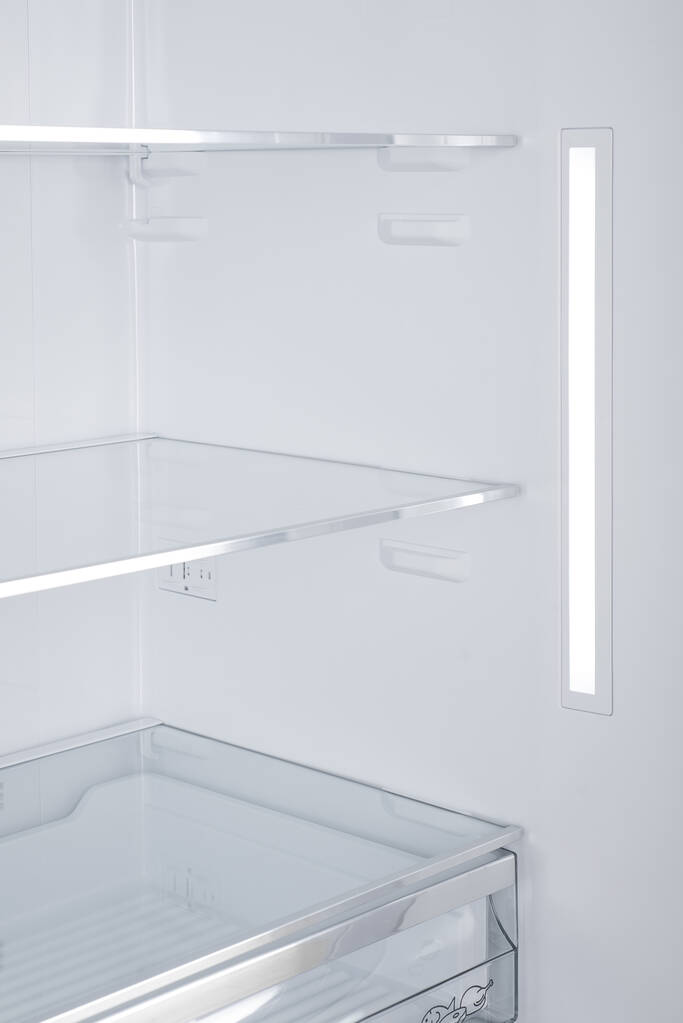

In [ ]:
Image_(r'..\dataset\YOLO - Raw datasets\Fridge\Fridge pictures\Fridge 11.jpg', width=400, height=200)

Cabe decir que para cada foto de nevera, se han definido las cajas delimitadas que representan las areas donde el scrip de python (definido posteriorment) puede colocar fotos de ingredientes aleatoriamente. Esto es para prevenir situaciones donde el script coloca fotos de alimentos en zonas que no son realistas. Véase el siguiente ejemplo:

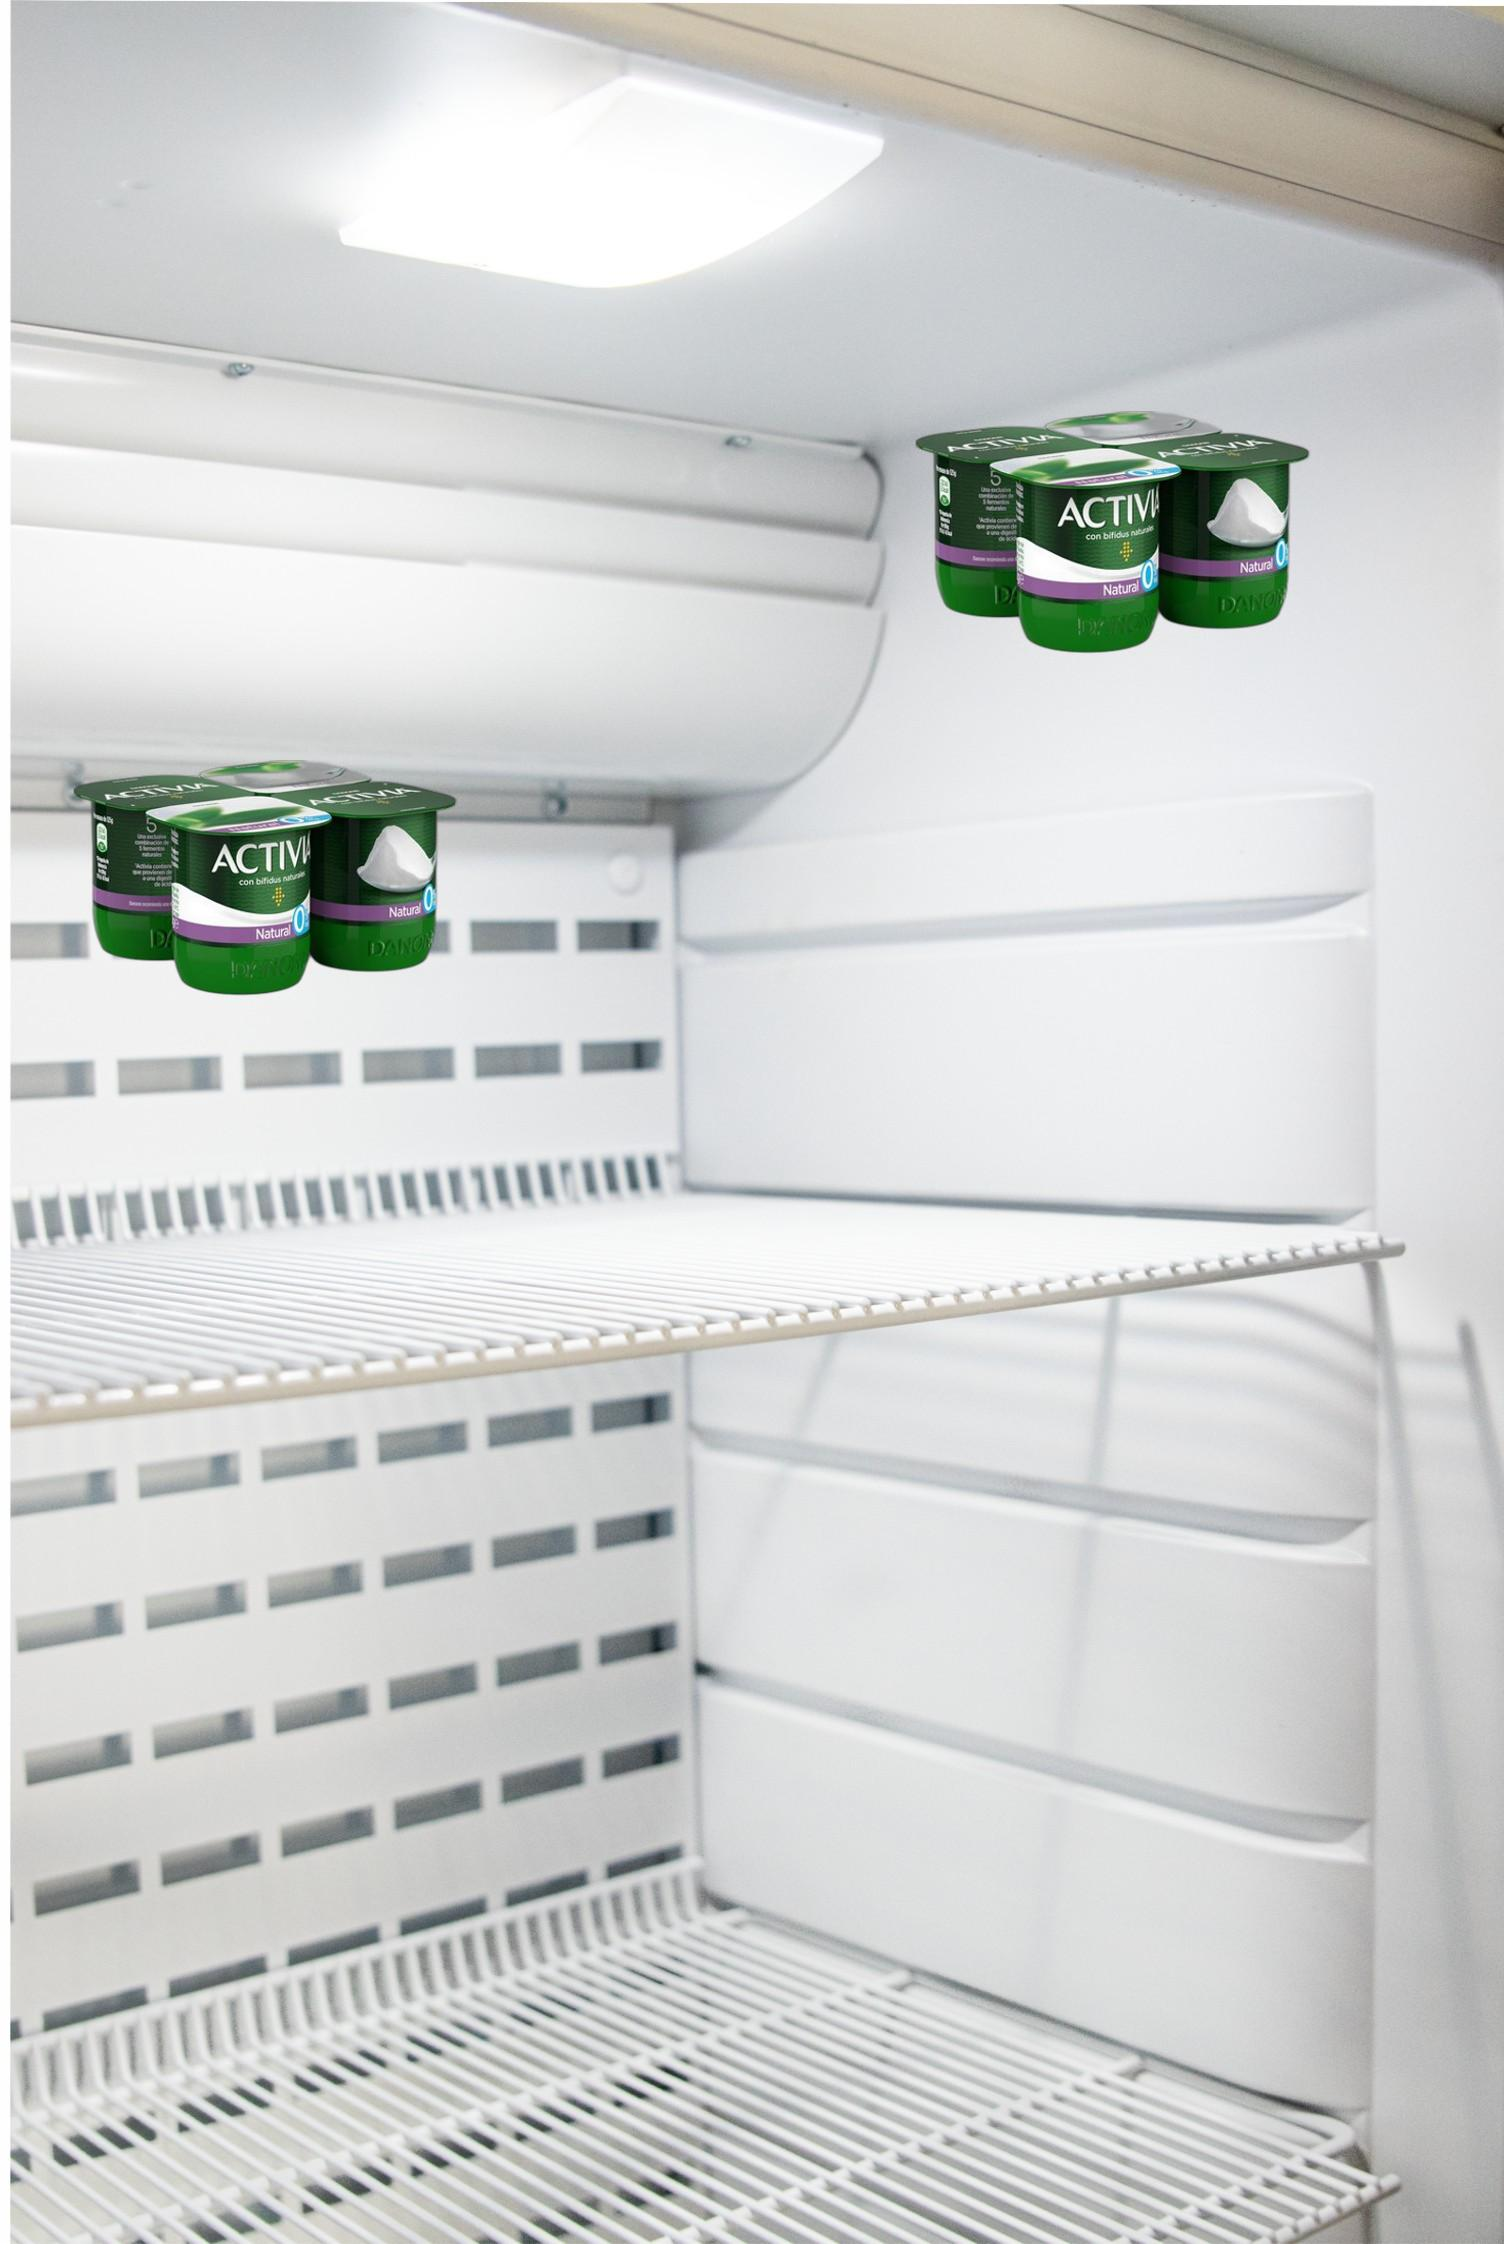

In [4]:
Image_(r'..\dataset\YOLO - Raw datasets\Bad synthetic data examples\Ejemplo de yogur flotando.jpg', width=200, height=150)

Tal y como se puede ver en la anterior imagen, las imágenes de yogur han sido colocados que parecen que estén flotando y hay otro directamente en la pared. Para evitar estos casos, se han delimitado zonas delimitadas donde el script puede posicionar alimentos (se ha utilizado el software online Roboflow Annotate). Teniendo las coordinadas de los bounding boxes, con el código se puede limitar donde van a ser posicionados los objetos para que sean posiciones lógicas y con sentido.

In [14]:
html = """
<div style="display: flex; gap: 20px;">
    <div>
        <p>Foto de nevera sin cajas delimitadas</p>
        <img src="../dataset\YOLO - Raw datasets\Fridge\Fridge pictures\Fridge 18.jpg" width="300">
    </div>
    <div>
        <p>Foto de nevera con las cajas delimitadas (las zonas permitidas para posicionar objetos)</p>
        <img src="../notebooks\examples\Fridge example.png" width="300">
    </div>
</div>
"""
display(HTML(html))

### 2.3) Generación de imágenes

Primero preparamos las rutas de los archivos y la estructura para la generación de imágenes sintéticas, se definen aspectos como máxima cantidad de objetos permitidos por zona y el punto de solapamiento.

In [ ]:
# Preparación de rutas y estructura para la generación
bg_path = r"..\dataset\YOLO - Raw datasets\Fridge\Fridge pictures labeled\images"
label_path = r"..\dataset\YOLO - Raw datasets\Fridge\Fridge pictures labeled\labels"
obj_path = r"..\dataset\YOLO - Raw datasets\Ingredients\Ingredients - without background"
output_images = r"..\dataset\YOLO - Raw datasets\Synthetic Dataset\images"
output_labels = r"..\dataset\YOLO - Raw datasets\Synthetic Dataset\labels"

os.makedirs(output_images, exist_ok=True)
os.makedirs(output_labels, exist_ok=True)

# Lista de clases del data.yaml
class_names = [
    "Tomate", "Cebolla", "Patata", "Lechuga/Endivia", "Zanahoria",
    "Calabacines", "Pepino", "Champiñones", "Brocoli", "Coliflor",
    "Leche", "Huevos", "Yogur", "Queso", "Mantequilla",
    "Merluza", "Gambas/Langostinos", "Mix de marisco/molusco", "Lubina", "Salmón",
    "Plátano", "Aguacate", "Sandía", "Limón", "Manzana",
    "Carne pollo", "Carne cerdo", "Carne vacuno", "Salchichas", "Carne pavo"
]
class_to_id = {name.lower(): i for i, name in enumerate(class_names)}

# Esta sección básicamente define cuantos objetos se permite tener por zona de nevera 
# y cuál es el punto de solapamiento permitido
MAX_OBJECTS_PER_ZONE = 2
MAX_IOU_ALLOWED = 0.3


A continuación, definimos las funciones necesarias para la generación de fotos.
Tal y como se ha mencionado anteriormente:
- Se ha definido la cantidad de objetos permitidos por zona
- Se ha definido un grado de solapamiento permitido

Si se sobrepasan estos límites, la función saltará el objeto y no lo posicionará.

In [9]:
# En esta sección encontraremos funciones procesadoras

def normalize_class(name_raw):
    """
    Normaliza el nombre de la imagen para que coincida con el formato esperado 
    en el diccionario `class_to_id`.

    Operaciones aplicadas:
    ----------------------
        - Convierte a minúsculas.
        - Elimina espacios en blanco al inicio y final.
        - Sustituye guiones y guiones bajos por "/".

    Parámetros:
    -----------
        name_raw: Nombre original de la clase (ej. "Carne_pavo-2").

    Devuelve:
    ---------
        str: Nombre de clase normalizado (ej. "carne pavo").
    """
    return name_raw.strip().lower().replace("-", "/").replace("_", "/")

def extract_clean_classname(filename):
    """
    Extrae el nombre del archivo de imagen y lo normaliza con la función definida previamente

    Flujo:
    ------
        - Elimina la extensión del archivo.
        - Quita sufijos numéricos comunes (ej. "_1", "-2").
        - Aplica la normalización definida en `normalize_class`.

    Devuelve:
    --------
        str: Nombre de clase limpio y normalizado (ej. "manzana").
    """
    base_name = os.path.splitext(filename)[0]
    clean_name = re.sub(r'[\s_\-]*\d+$', '', base_name).strip()
    return normalize_class(clean_name)

def load_yolo_boxes(label_file, img_w, img_h):
    """
    Esta función carga las cajas delimitadoras (bounding boxes) desde un archivo de etiquetas YOLO.
    Estas cajas delimitadoras son básicamente las coordenadas fijadas manualmente y son las zonas permitidas 
    dentro de las fotos de nevera donde se pueden colocar fotos de ingredientes.

    Convierte las coordenadas YOLO (normalizadas entre 0 y 1 respecto al tamaño de 
    la imagen) en coordenadas absolutas en píxeles, calculando las esquinas del 
    rectángulo.

    Parámetros:
    -----------
        label_file: Ruta al archivo `.txt` con anotaciones YOLO.
        img_w: Ancho de la imagen en píxeles.
        img_h: Alto de la imagen en píxeles.

    Devuelve:
    ---------
        list[tuple[int, int, int, int]]: Lista de cajas en formato (x1, y1, x2, y2),
        donde (x1, y1) es la esquina superior izquierda y (x2, y2) la esquina inferior derecha.
    """
    boxes = []
    if not os.path.exists(label_file):
        return boxes
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            _, x_c, y_c, w, h = map(float, parts)
            x1 = int((x_c - w / 2) * img_w)
            y1 = int((y_c - h / 2) * img_h)
            x2 = int((x_c + w / 2) * img_w)
            y2 = int((y_c + h / 2) * img_h)
            boxes.append((x1, y1, x2, y2))
    return boxes

def iou(box1, box2):
    xa = max(box1[0], box2[0])
    ya = max(box1[1], box2[1])
    xb = min(box1[2], box2[2])
    yb = min(box1[3], box2[3])
    inter_area = max(0, xb - xa) * max(0, yb - ya)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

object_files = [f for f in os.listdir(obj_path) if f.lower().endswith('.png')]

bg_files = [f for f in os.listdir(bg_path) if f.lower().endswith(('.jpg', '.png'))]

# Aquí definimos la cantidad de fotos sintéticas a generar
for i in range(1000):  
    bg_file = random.choice(bg_files)
    bg = Image.open(os.path.join(bg_path, bg_file)).convert("RGBA")
    bg_w, bg_h = bg.size

    label_file = os.path.join(label_path, os.path.splitext(bg_file)[0] + ".txt")
    allowed_zones = load_yolo_boxes(label_file, bg_w, bg_h)

    if not allowed_zones:
        print(f"Saltamos {bg_file}: no hay areas permitidas para posicionar la foto.")
        continue

    label_lines = []
    placed_boxes = []
    zone_usage = {}
    num_objects = random.randint(5, 10)

    for _ in range(num_objects):
        obj_file = random.choice(object_files)
        normalized_name = extract_clean_classname(obj_file)

        matched_id = class_to_id.get(normalized_name)
        if matched_id is None:
            print(f"Se ha saltado {obj_file} por clase desconocida")
            continue

        obj_orig = Image.open(os.path.join(obj_path, obj_file)).convert("RGBA")
        obj_w, obj_h = obj_orig.size
        placed = False

        for scale_threshold in [0.2, 0.05]:
            zones_shuffled = allowed_zones.copy()
            random.shuffle(zones_shuffled)

            for (x1, y1, x2, y2) in zones_shuffled:
                zone_key = (x1, y1, x2, y2)
                if zone_usage.get(zone_key, 0) >= MAX_OBJECTS_PER_ZONE:
                    continue

                box_w = x2 - x1
                box_h = y2 - y1

                scale = min(box_w / obj_w, box_h / obj_h, 1.0)
                if scale < scale_threshold:
                    continue

                obj = obj_orig.resize((int(obj_w * scale), int(obj_h * scale)))
                jitter = random.uniform(0.85, 1.0)
                obj = obj.resize((int(obj.width * jitter), int(obj.height * jitter)))

                if obj.width > box_w or obj.height > box_h:
                    continue

                pos_x = random.randint(x1, x2 - obj.width)
                pos_y = random.randint(y1, y2 - obj.height)
                new_box = (pos_x, pos_y, pos_x + obj.width, pos_y + obj.height)

                if any(iou(new_box, b) > MAX_IOU_ALLOWED for b in placed_boxes):
                    continue

                # Colocamos objetos
                bg.paste(obj, (pos_x, pos_y), obj)

                x_center = (pos_x + obj.width / 2) / bg_w
                y_center = (pos_y + obj.height / 2) / bg_h
                w_norm = obj.width / bg_w
                h_norm = obj.height / bg_h

                label_lines.append(f"{matched_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")
                placed_boxes.append(new_box)
                zone_usage[zone_key] = zone_usage.get(zone_key, 0) + 1
                placed = True
                break
            if placed:
                break

    if label_lines:
        img_name = f"fridge_synth_{i}.jpg"
        lbl_name = f"fridge_synth_{i}.txt"
        bg.convert("RGB").save(os.path.join(output_images, img_name))
        with open(os.path.join(output_labels, lbl_name), "w") as f:
            f.write("\n".join(label_lines))

print("Se han generado todas las imágenes")

Se han generado todas las imágenes


Exponemos algunos ejemplos de las fotos sintéticas generadas:

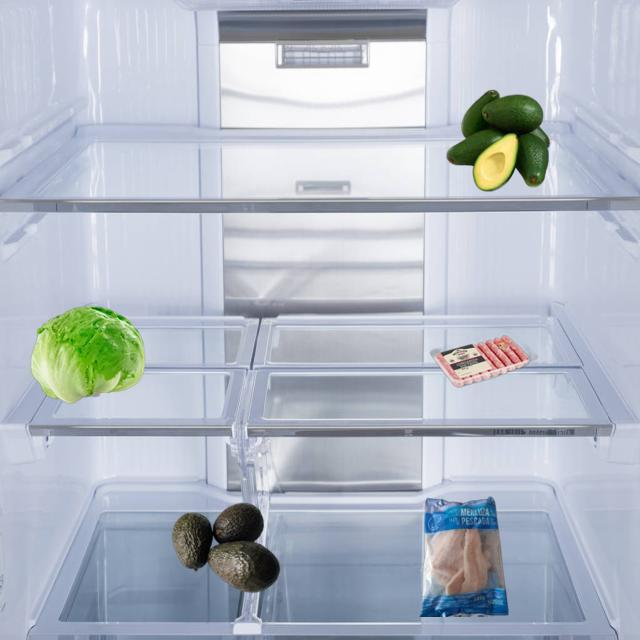

In [11]:
Image_(r'..\dataset\YOLO - Raw datasets\Synthetic Dataset\images\fridge_synth_22.jpg', width=350, height=150)

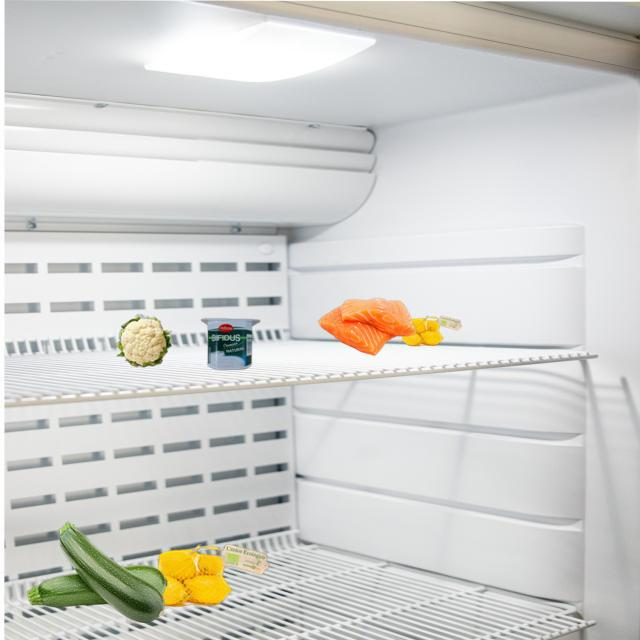

In [13]:
Image_(r'..\dataset\YOLO - Raw datasets\Synthetic Dataset\images\fridge_synth_973.jpg', width=400, height=150)

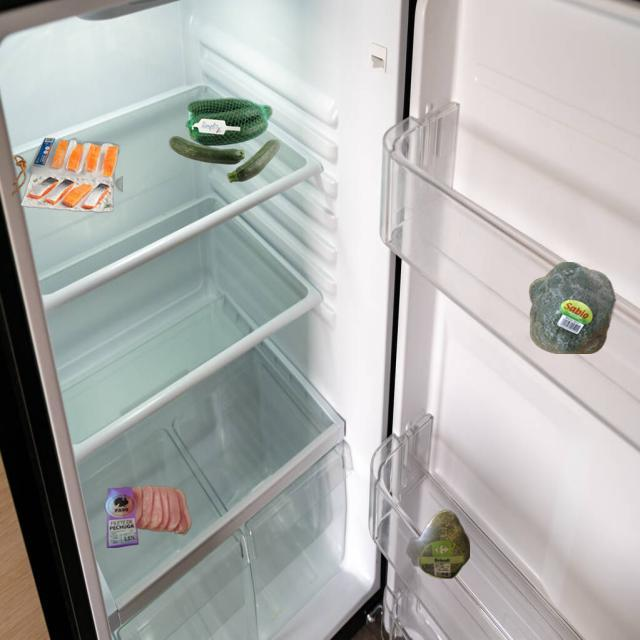

In [14]:
Image_(r'..\dataset\YOLO - Raw datasets\Synthetic Dataset\images\fridge_synth_962.jpg', width=400, height=150)

### 2.4) Data Augmentation

Con la función previa, hemos generado 1000 imágenes sintéticas. Estas imágenes han surgido como resultado de posicionar diferentes fotos de ingredientes aleatoriamente por las cajas delimitadas de las diferentes fotos de neveras. En esta última sección, realizaremos un último paso que aumentará más allá la diversidad de fotos. Se útiliza la técnica de *`data augmentation`*

La técnica de data augmentation en el contexto de YOLO se utiliza para aumentar artificialmente la diversidad y cantidad de datos de entrenamiento a partir de un conjunto de fotos ya disponible (en este caso, las 1000 imágenes que acabamos de generar). La razón por la cual no se ha elegido generar más imágenes simplemente con el script anterior es para evitar que el modelo aprenda de sólamente ejemplos "limpios" y acabe memorizando esos patrones. Las fotos reales que tomarán los usuarios probablemente contengan mucho más ruido, es decir, estarán torcidas, la cámara no es de buena calidad, la iluminación es pobre porque es de noche, etc. Para intentar replicar y simular estas situaciones, se utiliza data augmentation para aplicarle a las fotos generadas modificaciones como los siguientes:

- Rotaciones de la imagen.
- Inversión horizontal o vertical.
- Cambios en tono, saturación, brillo, contraste o color.
- Aplicación de ruido (como el gaussiano), desenfoque o recortes parciales.

El objetivo principal es mejorar la capacidad de generalización del modelo, evitando que aprenda patrones demasiado específicos del conjunto original y reduciendo el riesgo de overfitting. En resumen, el data augmentation en YOLO amplía la variedad de ejemplos de entrenamiento sin necesidad de recolectar nuevos datos, mejorando la precisión y la robustez del detector de objetos.

In [3]:
def augment_synthetic_dataset(
    img_dir, label_dir, output_img_dir, output_label_dir, num_aug_per_image=3
):

    """
    Esta función genera versiones modificadas de un set de fotos en formato YOLO usando Albumentations.

    Esta función toma imágenes y sus archivos de etiquetas en formato YOLO,
    aplica un conjunto de aumentaciones aleatorias (ej. volteo, cambios de brillo/contraste,
    rotación, desenfoque, ruido) y guarda las imágenes aumentadas junto con las 
    etiquetas ajustadas en los directorios de salida especificados. Cada imagen de entrada 
    puede generar múltiples versiones aumentadas.

    Parámetros
    ----------
    img_dir: Directorio que contiene las imágenes de entrada (en formato `.jpg`).
    label_dir: Directorio que contiene los archivos de etiquetas YOLO (`.txt`), con el mismo nombre base que las imágenes.
    output_img_dir: Directorio donde se guardarán las imágenes aumentadas.
    output_label_dir: Directorio donde se guardarán las etiquetas YOLO correspondientes a las imágenes aumentadas.
    num_aug_per_image: Número de versiones aumentadas a generar por cada imagen de entrada (por defecto 3).

    Notas
    -----
    - Aumentaciones que puede realizar aleatoriamente la función:
        * Volteo horizontal.
        * Variación de brillo/contraste.
        * Modificación de tono/saturación/valor.
        * Rotación (±15 grados).
        * Desenfoque gaussiano.
        * Ruido gaussiano.
    """

    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.3),
        A.Rotate(limit=15, p=0.4),
        A.GaussianBlur(blur_limit=3, p=0.3),
        A.GaussNoise(p=0.3)
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    image_files = [f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]

    for img_file in tqdm(image_files, desc="Augmenting images"):
        img_path = os.path.join(img_dir, img_file)
        lbl_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')

        if not os.path.exists(lbl_path):
            continue

        image = cv2.imread(img_path)
        if image is None:
            continue
        h, w = image.shape[:2]

        # Cargamos los labels de YOLO
        with open(lbl_path, 'r') as f:
            lines = f.readlines()

        if not lines:
            continue

        bboxes = []
        class_labels = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            try:
                class_id = int(float(parts[0]))  
                bbox = list(map(float, parts[1:])) 
                bboxes.append(bbox)
                class_labels.append(class_id)
            except ValueError:
                continue

        # Generamos tantas "augmentations" como se ha especificado en parámetros
        for j in range(num_aug_per_image):
            try:
                augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)

                aug_img = augmented['image']
                aug_bboxes = augmented['bboxes']
                aug_labels = augmented['class_labels']

                if not aug_bboxes:
                    continue

                new_name = os.path.splitext(img_file)[0] + f"_aug{j}"
                aug_img_path = os.path.join(output_img_dir, new_name + '.jpg')
                aug_lbl_path = os.path.join(output_label_dir, new_name + '.txt')

                cv2.imwrite(aug_img_path, aug_img)

                # Save corrected YOLO label
                with open(aug_lbl_path, 'w') as f:
                    for label, bbox in zip(aug_labels, aug_bboxes):
                        class_id = int(label)  # FIX: ensure integer class ID
                        bbox_str = ' '.join(f'{x:.6f}' for x in bbox)
                        f.write(f"{class_id} {bbox_str}\n")

            except Exception as e:
                print(f"No se ha podido aumentar {img_file} (aug{j}): {e}")


In [4]:
image_dir = r'..\dataset\YOLO - Raw datasets\Synthetic Dataset\images'
label_dir = r'..\dataset\YOLO - Raw datasets\Synthetic Dataset\labels'
augmented_images = r'..\dataset\YOLO - Raw datasets\Synthetic Dataset\augmented_images'
augmented_lables = r'..\dataset\YOLO - Raw datasets\Synthetic Dataset\augmented_label'
augment_synthetic_dataset(img_dir=image_dir, label_dir=label_dir, output_img_dir=augmented_images, output_label_dir=augmented_lables)

Augmenting images:  20%|█▉        | 198/1000 [00:07<00:30, 26.19it/s]

No se ha podido aumentar fridge_synth_273.jpg (aug0): Expected x_min for bbox [-4.991889e-07  8.015625e-01  2.328125e-01  9.749995e-01  1.700000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
No se ha podido aumentar fridge_synth_273.jpg (aug1): Expected x_min for bbox [-4.991889e-07  8.015625e-01  2.328125e-01  9.749995e-01  1.700000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
No se ha podido aumentar fridge_synth_273.jpg (aug2): Expected x_min for bbox [-4.991889e-07  8.015625e-01  2.328125e-01  9.749995e-01  1.700000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Augmenting images:  42%|████▏     | 418/1000 [00:15<00:18, 31.74it/s]

No se ha podido aumentar fridge_synth_470.jpg (aug0): Expected x_min for bbox [-5.0291419e-07  8.2343745e-01  1.2031250e-01  9.4375050e-01
  9.0000000e+00] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
No se ha podido aumentar fridge_synth_470.jpg (aug1): Expected x_min for bbox [-5.0291419e-07  8.2343745e-01  1.2031250e-01  9.4375050e-01
  9.0000000e+00] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
No se ha podido aumentar fridge_synth_470.jpg (aug2): Expected x_min for bbox [-5.0291419e-07  8.2343745e-01  1.2031250e-01  9.4375050e-01
  9.0000000e+00] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Augmenting images:  44%|████▎     | 435/1000 [00:16<00:17, 32.02it/s]

No se ha podido aumentar fridge_synth_486.jpg (aug0): Expected x_min for bbox [-4.9918890e-07  7.3437446e-01  2.3906249e-01  9.7343749e-01
  2.7000000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
No se ha podido aumentar fridge_synth_486.jpg (aug1): Expected x_min for bbox [-4.9918890e-07  7.3437446e-01  2.3906249e-01  9.7343749e-01
  2.7000000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
No se ha podido aumentar fridge_synth_486.jpg (aug2): Expected x_min for bbox [-4.9918890e-07  7.3437446e-01  2.3906249e-01  9.7343749e-01
  2.7000000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.


Augmenting images:  49%|████▉     | 492/1000 [00:18<00:19, 26.20it/s]

No se ha podido aumentar fridge_synth_537.jpg (aug0): Expected x_min for bbox [-5.029142e-07  8.203125e-01  1.203125e-01  9.234375e-01  9.000000e+00] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
No se ha podido aumentar fridge_synth_537.jpg (aug1): Expected x_min for bbox [-5.029142e-07  8.203125e-01  1.203125e-01  9.234375e-01  9.000000e+00] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
No se ha podido aumentar fridge_synth_537.jpg (aug2): Expected x_min for bbox [-5.029142e-07  8.203125e-01  1.203125e-01  9.234375e-01  9.000000e+00] to be in the range [0.0, 1.0], got -5.029141902923584e-07.


Augmenting images:  60%|██████    | 604/1000 [00:22<00:12, 32.71it/s]

No se ha podido aumentar fridge_synth_639.jpg (aug0): Expected x_min for bbox [-4.9918890e-07  4.5624948e-01  2.0156249e-01  6.5781248e-01
  1.8000000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
No se ha podido aumentar fridge_synth_639.jpg (aug1): Expected x_min for bbox [-4.9918890e-07  4.5624948e-01  2.0156249e-01  6.5781248e-01
  1.8000000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
No se ha podido aumentar fridge_synth_639.jpg (aug2): Expected x_min for bbox [-4.9918890e-07  4.5624948e-01  2.0156249e-01  6.5781248e-01
  1.8000000e+01] to be in the range [0.0, 1.0], got -4.991888999938965e-07.
No se ha podido aumentar fridge_synth_641.jpg (aug0): Expected x_min for bbox [-5.066395e-07  7.124995e-01  2.281245e-01  9.406245e-01  2.300000e+01] to be in the range [0.0, 1.0], got -5.066394805908203e-07.
No se ha podido aumentar fridge_synth_641.jpg (aug1): Expected x_min for bbox [-5.066395e-07  7.124995e-01  2.281245e-01  9.406245e-01  2.300000e+

Augmenting images: 100%|██████████| 1000/1000 [00:37<00:00, 26.74it/s]

No se ha podido aumentar fridge_synth_992.jpg (aug0): Expected x_min for bbox [-5.0291419e-07  8.2656246e-01  1.2031250e-01  9.4687551e-01
  2.4000000e+01] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
No se ha podido aumentar fridge_synth_992.jpg (aug1): Expected x_min for bbox [-5.0291419e-07  8.2656246e-01  1.2031250e-01  9.4687551e-01
  2.4000000e+01] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
No se ha podido aumentar fridge_synth_992.jpg (aug2): Expected x_min for bbox [-5.0291419e-07  8.2656246e-01  1.2031250e-01  9.4687551e-01
  2.4000000e+01] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
No se ha podido aumentar fridge_synth_995.jpg (aug0): Expected x_min for bbox [-5.0291419e-07  8.2187504e-01  1.2187450e-01  9.6562499e-01
  1.2000000e+01] to be in the range [0.0, 1.0], got -5.029141902923584e-07.
No se ha podido aumentar fridge_synth_995.jpg (aug1): Expected x_min for bbox [-5.0291419e-07  8.2187504e-01  1.2187450e-01  9.6562499e-01
 

### 2.5) Combinación de datasets
En este último paso, se procederá a combinar todos los datasets en uno final y se hará un split randomizado en trian, val, test. 

En total tenemos 4 datasets públicos procesados más 1 dataset sintético generado y transformado con técnicas de data augmentation. Se combinan los cinco sets de datos y se hace otra vez el conteo para ver en cuántas fotos aparece cada clase ahora para observar si hemos mitigado el problema de algunas clases no teniendo representación.


Class distribution in '..\dataset\YOLO - Clean dataset\Clean dataset 2\labels':

Tomate                         → 6379 image(s)
Cebolla                        → 3212 image(s)
Patata                         → 4245 image(s)
Lechuga/Endivia                → 2029 image(s)
Zanahoria                      → 4737 image(s)
Calabacines                    → 711 image(s)
Pepino                         → 1621 image(s)
Champiñones                    → 3238 image(s)
Brocoli                        → 1015 image(s)
Coliflor                       → 717 image(s)
Leche                          → 4664 image(s)
Huevos                         → 5170 image(s)
Yogur                          → 3565 image(s)
Queso                          → 6775 image(s)
Mantequilla                    → 4904 image(s)
Merluza                        → 966 image(s)
Gambas/Langostinos             → 3609 image(s)
Mix de marisco/molusco         → 777 image(s)
Lubina                         → 1101 image(s)
Salmón                       

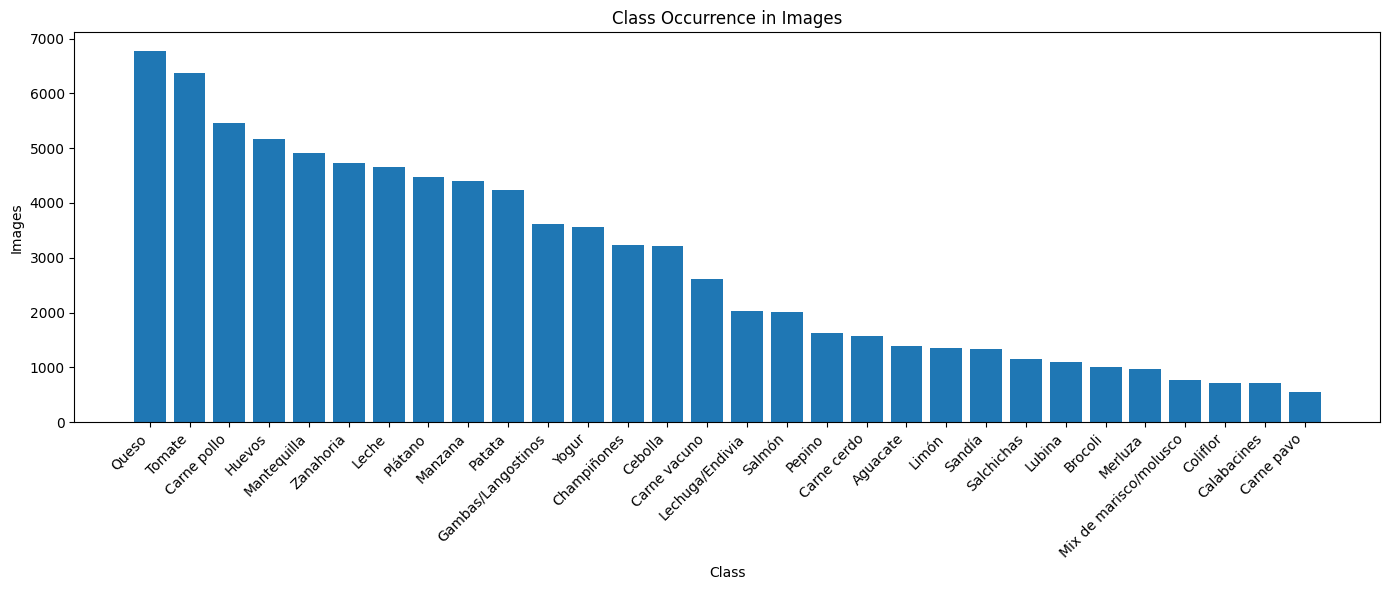

In [ ]:
target_classes = [
    "Tomate", "Cebolla", "Patata", "Lechuga/Endivia", "Zanahoria",
    "Calabacines", "Pepino", "Champiñones", "Brocoli", "Coliflor",
    "Leche", "Huevos", "Yogur", "Queso", "Mantequilla",
    "Merluza", "Gambas/Langostinos", "Mix de marisco/molusco", "Lubina", "Salmón",
    "Plátano", "Aguacate", "Sandía", "Limón", "Manzana", "Carne pollo", "Carne cerdo", "Carne vacuno", "Salchichas", "Carne pavo"
]

# Contamos en cuántas imágenes ha aparecido cada clase
counts = count_classes_in_images(r'..\dataset\YOLO - Clean dataset\Clean dataset 2\labels', class_names=target_classes)
full_counts = {i: counts.get(i, 0) for i in range(len(target_classes))} # Hace que se cuenten los que tiene 0 también
plot_class_image_distribution(full_counts, class_names=target_classes)

Por último, se realiza otra vez el split del dataset entero de forma aleatoria. Tal y como se ha hecho previamente en el punto 1.4) Split del dataset. Los ratios son los siguientes:
- 70% del dataset será utilizado para el entrenamiento (`train`)
- 15% del dataset será utilizado para la validación del entrenamiento (`val`)
- 15% será utilizado como datos nuevos no vistos por el modelo y para evaluar el modelo (`test`)

In [17]:
img_dir = r'..\dataset\YOLO - Clean dataset\Clean dataset 2\images'
label_dir = r'..\dataset\YOLO - Clean dataset\Clean dataset 2\labels'
output_dir = r'..\dataset\YOLO - Clean dataset\Clean dataset 2\split dataset'
split_yolo_dataset(image_dir=img_dir, label_dir=label_dir, output_dir=output_dir)

✅ Split complete:
   → Train: 11956
   → Val:   2562
   → Test:  2563
